<a href="https://colab.research.google.com/github/SmitaPaul7000/CaseStudies/blob/master/1.0%20Image%20Captioning/Code/1_0_Imag_Cap_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Version

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Data

In [0]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from PIL import Image
import string
from pickle import load

from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [0]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    #print(model.summary())
    # re-structure the model

    # remove last output layer from vgg16
    model.layers.pop()
    # print(model.summary())

    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    #print(model.summary())

    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name

        # for loading an image from file as a PIL image object.
        image = load_img(filename, target_size=(224, 224))
        #print(image)

        # convert the image pixels to a numpy array
        image = img_to_array(image)
        #print(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        #print(image)

        # prepare the image for the VGG model
        image = preprocess_input(image)
        #print("1.2")
        #print(image)

        # get features
        feature = model.predict(image, verbose=0)
        #print("1.3")
        #print(feature)
        #print(feature.shape)
    
        # get image id
        image_id = name.split('.')[0]
        #print(image_id)
        # store feature
        features[image_id] = feature
        # print('>%s' % name)
        #break
    return features



# 2. Features extraction using VGG16 for all 8K Images


In [8]:
# extract features from all images
directory = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

Extracted Features: 8091


Check images in folders

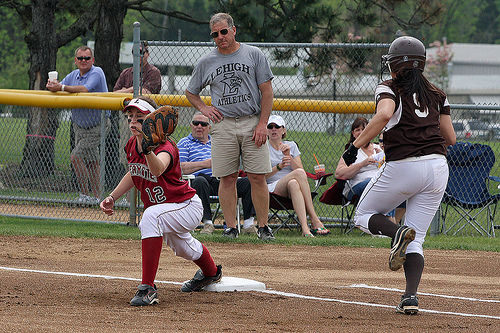

In [9]:
Image.open('/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/3517040752_debec03376.jpg')

In [10]:
features['3517040752_debec03376'].shape
#features[''] 

(1, 4096)

# 3.Save features of images in file AllImageFeatures.pkl, into google drive


In [0]:
# save to file
##dump(features, open('AllImageFeatures.pkl', 'wb'))

In [0]:
feature_save_name = 'AllImageFeatures_8K.pkl'
path = F"/content/drive/My Drive/Colab Notebooks/_ic/results/{feature_save_name}"
dump(features, open(path, 'wb')) 

# 4.Image id and desciption

4.1 Create dictionary with image id and image description



In [0]:
#Flickr8k.token.txt contain image id and 3-4 line description for image
Flickr8k_token_filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr8k.token.txt'

# load descriptions
file = open(Flickr8k_token_filename, 'r')
doc = file.read()
file.close() 

mapping = dict()
#i = 1
# process lines
for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  if len(line) < 2:
    continue
  # take the first token as the image id, the rest as the description
  image_id, image_desc = tokens[0], tokens[1:]
  # remove filename from image id
  image_id = image_id.split('.')[0]
  # convert description tokens back to string
  image_desc = ' '.join(image_desc)
  
  # create the list if needed, else appende description to existing image id
  if image_id not in mapping:
    mapping[image_id] = list()
    # store description
  mapping[image_id].append(image_desc)    
  #i = i+1
  #if i==10 :
  #  break
Flickr8k_token_descriptions =mapping

4.2 Text preprocessing, cleaning up data
Lower case
Remove puntations
Remove 's' and 'a'
Remove numbers


** -- TO DO: unused code


In [0]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in Flickr8k_token_descriptions.items():
  for i in range(len(desc_list)):
    desc = desc_list[i]
    # tokenize
    desc = desc.split()
    # convert to lower case
    desc = [word.lower() for word in desc]
    # remove punctuation from each token
    desc = [w.translate(table) for w in desc]
    # remove hanging 's' and 'a'
    desc = [word for word in desc if len(word)>1]
    # remove tokens with numbers in them
    desc = [word for word in desc if word.isalpha()]
    # store as string
    desc_list[i] =  ' '.join(desc)

In [20]:
desc

['rock', 'climber', 'practices', 'on', 'rock', 'climbing', 'wall']

4.3 Convert the loaded descriptions (text) into a vocabulary of words

In [0]:
# build a list of all description strings
all_desc = set()
for key in Flickr8k_token_descriptions.keys():
  [all_desc.update(d.split()) for d in Flickr8k_token_descriptions[key]]


In [18]:
Flickr8k_token_descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with pi

In [30]:
all_desc
type(desc_list)

list

4.4 Save descriptions to file, one per line : AllImageDescriptions.txt


In [0]:
# save descriptions to file, one per line
lines = list()
for key, desc_list in Flickr8k_token_descriptions.items():
  for desc in desc_list:
    lines.append(key + ' ' + desc)
data = '\n'.join(lines)




In [23]:
len(data)

2943284

In [0]:
desc_save_name = 'AllImageDescriptions_8K.txt'
path = F"/content/drive/My Drive/Colab Notebooks/_ic/results/{desc_save_name}"
# dump(features, open(path, 'wb')) 

file = open(path, 'w')
file.write(data)
file.close()

# 5.Train on Flickr_8k.trainImages.txt

5.1 Train Images data

In [0]:
# load a pre-defined list of photo identifiers
Flickr_8k_trainImages_filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
file = open(Flickr_8k_trainImages_filename, 'r')
train_img_id_data = file.read()
file.close()

train_img_id_dataset = list()
# process line by line
for line in train_img_id_data.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  train_img_id_dataset.append(identifier)


In [36]:
type(train_img_id_dataset)
train_img_id_dataset[:10]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

5.2 Train Image descriptions with startseq and endseq


In [0]:
##To DO: rewrite code for skiiping this coe
## this coe will take desc for train images

# load document
filename = '/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageDescriptions_8K.txt'
file = open(filename, 'r')
all_desc_8k = file.read()
file.close()

train_descriptions = dict()
for line in all_desc_8k.split('\n'):
  # split line by white space
  tokens = line.split()

  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  
  # skip images not in the set
  if image_id in train_img_id_dataset:
    # create list
    if image_id not in train_descriptions:
      train_descriptions[image_id] = list()

    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    
    # store
    train_descriptions[image_id].append(desc)


In [38]:
len(features) #, len(all_features)

8091

5.3 Image id and its features from VGG16

In [0]:
# photo features
# load all image features
filename = '/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageFeatures_8K.pkl'
all_features = load(open(filename, 'rb'))
# filter features
train_img_features = {k: all_features[k] for k in train_img_id_dataset}


In [42]:
len(train_img_features) , len(all_features)

(6000, 8091)

# Traning Dataset

To check ***********************************
BELOW STEP IS REPETATIVE, ALREADY TOOK TRAIN DATA ABOVE

In [46]:
type(train_img_id_dataset), len(train_img_id_dataset)
train_img_id_dataset[:10]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

In [63]:
len(train_descriptions), type(train_descriptions)
#train_descriptions.most_common(3)
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [47]:
# load training dataset (6K)
filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
#train = load_set(filename)
#doc = load_doc(filename)
file = open(filename, 'r')
doc = file.read()
file.close()

dataset = list()
# process line by line
for line in doc.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)
train = set(dataset)
 
print('Dataset: %d' % len(train))



Dataset: 6000


In [49]:
type(train), len(train)
train


{'241031670_e60f59b8e4',
 '3399618896_9ef60cd32c',
 '2276499757_b44dc6f8ce',
 '162152393_52ecd33fc5',
 '532914728_c5d8d56b0b',
 '391106734_d374bc3080',
 '241347823_6b25c3e58e',
 '3344526059_4a097af285',
 '1460500597_866fa0c6f3',
 '486300784_2cc7a770ff',
 '3298233193_d2a550840d',
 '2823200990_7b02b7cc36',
 '2326730558_75c20e5033',
 '760138567_762d9022d4',
 '1515883224_14e36a53c7',
 '2990977776_1ec51c9281',
 '3239480519_22540b5016',
 '3243591844_791cfa62eb',
 '2034553054_b00c166895',
 '2896180326_88785fe078',
 '174466741_329a52b2fe',
 '3445428367_25bafffe75',
 '3341084434_db5e7d1fdc',
 '2591455200_2319651f2f',
 '480200554_6155e9dfeb',
 '2214132302_80064fd79d',
 '3111502208_71e2a414f5',
 '3259883609_6a1b46919e',
 '3210457502_c6030ce567',
 '3078844565_16e9cdcea2',
 '566446626_9793890f95',
 '2815745115_c8479d560c',
 '2623560640_0445c9a138',
 '542648687_adf13c406b',
 '3487261028_30791528ec',
 '2716251485_d6113f4c8a',
 '3392851587_a638ff25e2',
 '3559425864_0462d7613f',
 '2629445284_83390e83af

#### Description
****************** REPETATIVE STEP

In [60]:
# # descriptions
#train_descriptions = load_clean_descriptions('descriptions.txt', train)
# load document
file = open('/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageDescriptions_8K.txt', 'r')
doc = file.read()
file.close()

descriptions = dict()

for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)
train_descriptions1 =  descriptions

print('Descriptions: train=%d' % len(train_descriptions1))


Descriptions: train=6000


In [62]:
train_descriptions1

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

** REPETATIVE STEP

In [64]:
# # photo features
#train_features = load_photo_features('features.pkl', train)
all_features = load(open('/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageFeatures_8K.pkl', 'rb'))
# filter features
features = {k: all_features[k] for k in dataset}
train_features1= features

print('Photos: train=%d' % len(train_features1))


Photos: train=6000


#### prepare tokenizer for train dataset
*************------- to do what tokenizer doing?


In [0]:
#tokenizer = create_tokenizer(train_descriptions)
#lines = to_lines(descriptions)
all_desc = list()
for key in descriptions.keys():
  [all_desc.append(d) for d in train_descriptions[key]]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)



In [69]:
tokenizer

take max length 

In [70]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
# print('Description Length: %d' % max_length)
#lines = to_lines(descriptions)
all_desc = list()
for key in train_descriptions.keys():
  [all_desc.append(d) for d in train_descriptions[key]]

max_length =  max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 33


# 6.Train the model

In [71]:
# train the model
# model = define_model(vocab_size, max_length)


# feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


model.compile(loss='categorical_crossentropy', optimizer='adam')


# summarize model
print(model.summary())

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:

		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)
 
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

# train the model, run epochs manually and save after each epoch
#epochs = 20
epochs = 10
steps = len(train_descriptions)

#To Do: chk code epoch...
# it cud be written better way
for i in range(epochs):
	# create the data generator
	# pass all input HERE
	#generator = data_generator(train_descriptions, train_features1, tokenizer, max_length)
	
	generator = data_generator(train_descriptions, train_img_features, tokenizer, max_length)
 

	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
 
	# save model for each epoch
	model.save('model_' + str(i) + '.h5')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 256)      1940224     input_4[0][0]                    
______________________________________________________________________________

# 7. Test Images 
Entire code with all the functions, for reference purpose


In [0]:
# # load training dataset (6K)
# filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
# #train = load_set(filename)

# file = open(filename, 'r')
# doc = file.read()
# file.close()

# dataset = list()
# # process line by line
# for line in doc.split('\n'):
#   # skip empty lines
#   if len(line) < 1:
#     continue
#   # get the image identifier
#   identifier = line.split('.')[0]
#   dataset.append(identifier)
# train = set(dataset)


# print('Dataset: %d' % len(train))


7.1 Test Image Description
To Do :again train image why????
dele it

In [0]:
# # descriptions
# #train_descriptions = load_clean_descriptions('descriptions.txt', train)
# # load document
# #doc = load_doc(filename)
# file = open('AllImageDescriptions.txt', 'r')
# doc = file.read()
# file.close()

# dataset = train
# descriptions = dict()
# for line in doc.split('\n'):
#   # split line by white space
#   tokens = line.split()
#   # split id from description
#   image_id, image_desc = tokens[0], tokens[1:]
#   # skip images not in the set
#   if image_id in dataset:
#     # create list
#     if image_id not in descriptions:
#       descriptions[image_id] = list()
#     # wrap description in tokens
#     desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
#     # store
#     descriptions[image_id].append(desc)
# train_descriptions = descriptions


# print('Descriptions: train=%d' % len(train_descriptions))


7.2 Prepare tokenizer

In [0]:
# # prepare tokenizer
# #tokenizer = create_tokenizer(train_descriptions)
# #lines = to_lines(descriptions)
# descriptions = train_descriptions
# all_desc = list()
# for key in descriptions.keys():
#   [all_desc.append(d) for d in descriptions[key]]
# lines = all_desc

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(lines)

# vocab_size = len(tokenizer.word_index) + 1
# print('Vocabulary Size: %d' % vocab_size)
# # determine the maximum sequence length
# #max_length = max_length(train_descriptions)
# #lines = to_lines(train_descriptions)
# all_desc = list()
# for key in train_descriptions.keys():
#   [all_desc.append(d) for d in train_descriptions[key]]
# lines = all_desc    
# max(len(d.split()) for d in lines)
# print('Description Length: %d' % max_length)

#8 prepare test set

In [72]:
# prepare test set

# load test set
Flickr_8k_testImages_filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.testImages.txt'
#test = load_set(filename)
file = open(Flickr_8k_testImages_filename, 'r')
test_img_id_data = file.read()
file.close()

dataset = list()
# process line by line
for line in test_img_id_data.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)
test_img_id =set(dataset)

print('Dataset: %d' % len(test_img_id))


Dataset: 1000


In [73]:
# descriptions
#test_descriptions = load_clean_descriptions('descriptions.txt', test)
file = open('/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageDescriptions_8K.txt', 'r')
all_desc_8k = file.read()
file.close()

# load document
#doc = load_doc(filename)
descriptions = dict()
for line in all_desc_8k.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)
test_img_descriptions = descriptions


print('Descriptions: test=%d' % len(test_img_descriptions))


Descriptions: test=1000


In [75]:
# for k in test_img_descriptions:
#   print(k)
#   break

1056338697_4f7d7ce270


7.3 test photo features

In [76]:
# photo features
#test_features = load_photo_features('features.pkl', test)
# load all features
all_features = load(open('/content/drive/My Drive/Colab Notebooks/_ic/results/AllImageFeatures_8K.pkl', 'rb'))
# filter features
features = {k: all_features[k] for k in test_img_descriptions}
test_img_features = features

print('Photos: test=%d' % len(test_img_features))


Photos: test=1000


7.4 load the model which has minimum loss, in this case it was model_18

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
  
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]

		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		
		# convert probability to integer
		yhat = argmax(yhat)
		
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		
		# stop if we cannot map the word
		if word is None:
			break
		
		# append as input for generating the next word
		in_text += ' ' + word
		
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	
	return in_text

#9 Metric Bleu

In [0]:
def predict_n_chk_score(model_nm):
  model = load_model(model_nm)
  # evaluate model
  #evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

  # evaluate the skill of the model
  #def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()

  # step over the whole set
  for key, desc_list in test_img_descriptions.items():

    # generate description
    yhat = generate_desc(model, tokenizer, test_img_features[key], max_length)
    
    # store actual and predicted
    references = [d.split() for d in desc_list]
    
    actual.append(references)
    predicted.append(yhat.split())


  # calculate BLEU score
  # cumulative scores for BLEU-1, BLEU-2, BLEU-3 and BLEU-4:
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



In [105]:
actual[:1], predicted[:1]

([[['startseq',
    'blond',
    'woman',
    'in',
    'blue',
    'shirt',
    'appears',
    'to',
    'wait',
    'for',
    'ride',
    'endseq'],
   ['startseq',
    'blond',
    'woman',
    'is',
    'on',
    'the',
    'street',
    'hailing',
    'taxi',
    'endseq'],
   ['startseq',
    'woman',
    'is',
    'signaling',
    'is',
    'to',
    'traffic',
    'as',
    'seen',
    'from',
    'behind',
    'endseq'],
   ['startseq',
    'woman',
    'with',
    'blonde',
    'hair',
    'wearing',
    'blue',
    'tube',
    'top',
    'is',
    'waving',
    'on',
    'the',
    'side',
    'of',
    'the',
    'street',
    'endseq'],
   ['startseq',
    'the',
    'woman',
    'in',
    'the',
    'blue',
    'dress',
    'is',
    'holding',
    'out',
    'her',
    'arm',
    'at',
    'oncoming',
    'traffic',
    'endseq']]],
 [['startseq',
   'two',
   'girls',
   'are',
   'sitting',
   'on',
   'the',
   'street',
   'endseq']])

In [99]:
predicted

[['startseq',
  'two',
  'girls',
  'are',
  'sitting',
  'on',
  'the',
  'street',
  'endseq'],
 ['startseq',
  'boy',
  'in',
  'red',
  'shirt',
  'is',
  'jumping',
  'into',
  'the',
  'water',
  'endseq'],
 ['startseq',
  'man',
  'in',
  'red',
  'shirt',
  'is',
  'walking',
  'down',
  'the',
  'beach',
  'endseq'],
 ['startseq', 'two', 'dogs', 'are', 'playing', 'in', 'the', 'water', 'endseq'],
 ['startseq', 'young', 'boy', 'is', 'playing', 'on', 'the', 'grass', 'endseq'],
 ['startseq',
  'black',
  'dog',
  'is',
  'running',
  'through',
  'the',
  'grass',
  'endseq'],
 ['startseq', 'dog', 'is', 'running', 'through', 'the', 'grass', 'endseq'],
 ['startseq',
  'two',
  'girls',
  'are',
  'sitting',
  'on',
  'the',
  'street',
  'endseq'],
 ['startseq', 'two', 'dogs', 'are', 'playing', 'in', 'the', 'water', 'endseq'],
 ['startseq',
  'two',
  'children',
  'are',
  'playing',
  'on',
  'the',
  'grass',
  'endseq'],
 ['startseq',
  'man',
  'in',
  'red',
  'shirt',
  'is'

In [89]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_0.h5')
'''BLEU-1: 0.558747
BLEU-2: 0.305061
BLEU-3: 0.209501
BLEU-4: 0.095505'''

BLEU-1: 0.547449
BLEU-2: 0.295280
BLEU-3: 0.197431
BLEU-4: 0.088339


'BLEU-1: 0.558747\nBLEU-2: 0.305061\nBLEU-3: 0.209501\nBLEU-4: 0.095505'

In [90]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_2.h5')

BLEU-1: 0.548080
BLEU-2: 0.302812
BLEU-3: 0.209856
BLEU-4: 0.100238


In [91]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_8.h5')

BLEU-1: 0.528554
BLEU-2: 0.282722
BLEU-3: 0.189347
BLEU-4: 0.085361


In [92]:
predict_n_chk_score('/content/drive/My Drive/Colab Notebooks/_ic/results/model_9.h5')

BLEU-1: 0.525474
BLEU-2: 0.278177
BLEU-3: 0.185752
BLEU-4: 0.083023


In [96]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test','pole']]
candidate = ['pole','this', 'is', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.778801
Individual 2-gram: 0.259600
Individual 3-gram: 0.778801
Individual 4-gram: 0.778801


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [97]:
# 4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

0.7071067811865475


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [98]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.500000
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.707107


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# pls check actual and predicted sentence with images


In [0]:
num_tests = 2
for tests in range(num_tests):
  image_num = random.randint(0, sample_size - 1)
  caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
  print(caption.shape)
  caption = np.argmax(caption[:-1], 1)
  capt = ''
  for i in caption:
      capt += rev_dict[i] + ' '
  print('Predicted Caption:->', capt)
  orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
  orignalcaption = ''
  for i in orig_cap:
      orignalcaption += rev_dict[i] + ' '
  print('Orignal Caption:->', orignalcaption)
  plt.imshow(real_images[image_num])
  plt.title('Image')
  plt.show()

# 10.Generate caption for Fresh image


In [79]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33
# load the model
model = load_model('model_1.h5')
# load and prepare the photograph
#photo = extract_features('Sample_Image.jpg')
photo = extract_features('/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#startseq man rides bike on dirt path endseq


startseq two children are playing on the beach endseq


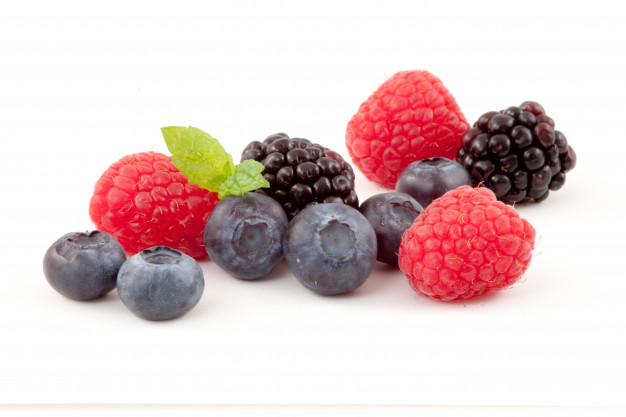

In [81]:
Image.open('/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg')

#### Other code

In [82]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

img_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

58892288/58889256 [==============================] - 5s 0us/step


In [0]:
#features

#Image.open(img_path)

In [83]:
features.shape

(1, 7, 7, 512)

In [0]:
img_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg'

In [0]:
import tensorflow as tf
#img = read_file(img_path)
#img = image.load_img(img_path)
img = image.load_img(img_path, target_size=(224, 224))
#img = tf.image.decode_jpeg(img, channels=3)
#img = tf.image.resize(img, (299, 299))
#img = preprocess_input(img)
#features = model.predict(img)

In [86]:

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
print(x.shape)
features = model.predict(x)
features.shape

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


(1, 7, 7, 512)